# 🔀 **Scalable data processing in the Cloud with DASK**

### **Workflow with SAGE data**

This notebook introduces `dask`, a Python library for parallel and distributed computing. `dask` allows to scale up your Python code and data processing workflows to handle larger-than-memory datasets and leverage multiple cores. With the help of `dask`, you can easily scale a wide array of solutions and configure your project to use most of the available computational power. It helps developers scale their entire Python ecosystem, and it can work with your laptop or a container cluster. The best part is that you don’t need to rewrite your entire codebase, you just have to enable parallel computing with minimal modifications based on your use cases.

##### 🔹 **Why this matters?** 
`dask` can,
- run your code in parallel on single machine/mutiple cores/cluster of machines.
- handle larger than memory datasets to process and analyze them efficiently.
- integrate seamlessly with popular Python libraries like NumPy, Pandas, and scikit-learn
- use a dynamic task scheduler to manage and optimize the execution of code
- collect the results from the executed tasks and combines them to produce the final output


<img src="https://docs.2i2c.org/_images/scalable_research_hub.png" alt="DASKscaling" width="550"/> 

##### 🔹 **What you will do?** 
- Using directed graphs discover how to parallelize your geophysical research workflow
- Few basic concepts on `dask` array and dataframe
- Implement parallelism to your existing workflow using `dask.delayed`
- Deploy `dask` in the cloud to download and analyze the seismic data

*Below is a simplified overview of `dask` architecture ⤵️*

***Scheduler ↔ Workers ↔ Client***

<img src="https://user-images.githubusercontent.com/306380/129031260-ad9600b0-1942-40ad-99a7-694ea2d3a382.jpg" alt="DASK" width="550"/> 

---

### **1. Workflow Parallelization**

In this section, you're introduced to **workflow parallelization** using Directed Acyclic Graphs (DAGs), a foundational concept in scalable computing with libraries like `dask`. DAGs allow us to break down complex, multi-step workflows into discrete, interdependent tasks — making it easier to identify which processes can be executed in parallel rather than sequentially.

You'll start by visualizing the parallelization potential in a typical waveform processing pipeline. This example mimics a simplified seismic analysis using data from multiple stations, and demonstrates how task-level parallelism is encoded using a DAG.

##### **Why DAGs?**
A DAG represents tasks (nodes) and their dependencies (edges) in a one-way structure — no loops, no cycles. This allows us to:
- Visually understand task order and dependencies.
- Identify opportunities for parallel execution.
- Optimize computation by minimizing idle time.

In the context of the `trad_vs_cloud-SAGE.ipynb` notebook, this DAG represents a pipeline where:
- Waveforms from multiple stations are processed.
- Shared preprocessing steps (like inventory loading) feed into independent station-specific tasks.
- Results eventually converge into common postprocessing steps.

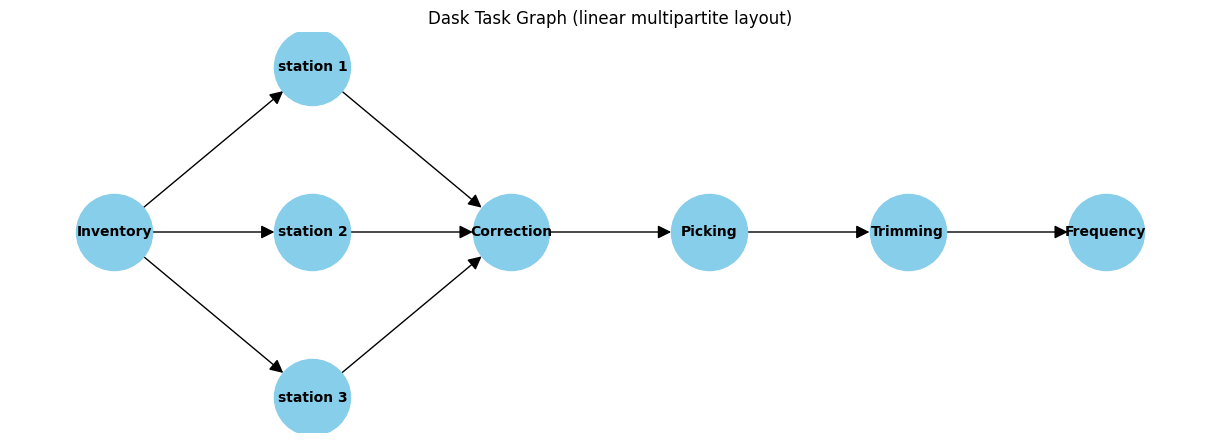

In [40]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Divide  workflow into different tasks
Task1 = 'Inventory'
Task2_1, Task2_2, Task2_3 = 'station 1', 'station 2', 'station 3' # suppose we are accessing waveforms for three stations
Task3 = 'Correction'
Task4 = 'Picking'
Task5 = 'Trimming'
Task6 = 'Frequency'

# Add nodes for tasks
G.add_node(Task1) 
G.add_node(Task2_1), G.add_node(Task2_2), G.add_node(Task2_3)  
G.add_node(Task3)
G.add_node(Task4)
G.add_node(Task5)
G.add_node(Task6)
# Add edges to show dependencies
G.add_edges_from([(Task1, Task2_1), (Task1, Task2_2), (Task1, Task2_3),
                  (Task2_1, Task3), (Task2_2, Task3), (Task2_3, Task3),
                  (Task3, Task4), (Task4, Task5), (Task5, Task6)])

# annotate each node with its stage
layers = {
    Task1:         0,
    Task2_1:       1,
    Task2_2:       1,
    Task2_3:       1,
    Task3:         2,
    Task4:         3,
    Task5:         4,
    Task6:         5
}

for n, L in layers.items():
    G.nodes[n]['layer'] = L

plt.figure(figsize=(12, 4))
pos = nx.multipartite_layout(G, subset_key='layer', align='vertical')
nx.draw(G, pos,
        with_labels=True,
        node_size=3000,
        node_color="skyblue",
        font_size=10,
        font_weight="bold",
        arrowsize=20)
plt.title("Dask Task Graph (linear multipartite layout)")
plt.axis('off')
plt.show()

This example serves as a realistic analog of seismic workflows in cloud environments, where tasks such as waveform retrieval and preprocessing for multiple stations can be executed independently — a classic case of what's known as an **embarrassingly parallel** problem. In such problems, individual tasks require little to no communication with one another, making them ideal candidates for concurrent execution across distributed computing resources. In the context of seismology, each station's data can be fetched, corrected, and processed in isolation before being merged downstream for higher-level analysis. By leveraging cloud-based parallelization frameworks like Dask, we can significantly reduce total computation time through intelligent task scheduling and resource allocation.

---

### **2. DASK Array and Dataframe**

##### **Array**

Dask array represents a large, potentially out-of-core, multi-dimensional array composed of many smaller `numpy` arrays (called ***chunks***) arranged in a grid.

The `dask.array` module is a powerful tool for handling large, multi-dimensional arrays that don't fit in memory, by breaking them into smaller pieces (called chunks) that are processed in parallel. Conceptually, it extends the familiar `numpy` API, allowing scientists and engineers to work with big data as if they were working with in-memory arrays — all while abstracting away the complexity of parallelization and memory management.

Think of a Dask array as a grid of many small `numpy` arrays, seamlessly stitched together. But unlike NumPy, where operations happen immediately, Dask builds a **lazy execution graph**: it constructs a task graph first, and only executes the computation when explicitly told to.

**Key features of dask array:**
- **Lazy evaluation:** All operations (e.g., +, mean, slicing) construct a task graph first. This avoids unnecessary intermediate results and optimizes performance.
- **Chunkwise operations:** Dask processes one chunk at a time using familiar NumPy-style syntax, enabling computations on datasets much larger than memory.
- **Scalable execution:** The same code can run on your laptop or scale to a multi-node cluster without modification — perfect for both prototyping and production workloads.

<img src="https://docs.dask.org/en/stable/_images/dask-array.svg" alt="DASK_array" width="550"/> 

In [14]:
import dask.array as da

# Create a 1000 x 1000 array of zeros, chunked into 10 x 10 blocks
x = da.zeros((1000, 1000), chunks=(10, 10))

# Apply a simple operation: add 5 to each element
y = x + 5  # This builds a task graph, but does not execute anything yet

# Take the mean (also lazy, still no computation)
result = y.mean()

# Trigger the actual computation across all chunks and cores
result.compute()

np.float64(5.0)

> *⭕ **Reflection Question**: In what scenarios would using a Dask array not be the optimal choice, even if you're working with large datasets — and how would you decide between using Dask, NumPy, or another tool like Xarray or pandas?*

##### **dataframe**

Dask dataframe is a large table of data composed of many smaller `pandas` DataFrames (partitions), split along the index.

A Dask DataFrame allows you to work with tabular data that is too large to fit into memory by dividing it into many smaller `pandas` DataFrame partitions, each of which is processed in parallel. If you're already comfortable using `pandas`, transitioning to `dask.dataframe` is relatively smooth — it implements a large subset of the familiar Pandas API and behavior.

Imagine having 100 GB of CSV files. Loading all of that into memory with Pandas would crash most machines. Dask sidesteps this limitation by lazily loading and operating on partitioned data, one chunk at a time, allowing you to analyze enormous datasets even on a laptop.

**Key features of dask dataframe:**
- **Pandas-compatible interface:** Uses similar syntax for filtering, grouping, and aggregating data.
- **Lazy evaluation:** Operations are not executed until .compute() is explicitly called.
- **Parallel execution:** Each partition is processed independently, enabling significant speed-ups on multi-core machines or clusters.
- **Out-of-core computation:** Easily handles data that exceeds available RAM by streaming in partitions as needed.

<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg" alt="DASK_array" width="400"/> 

In [ ]:
import dask.dataframe as dd

# Read a collection of CSV files (≈100 GB total) as a single Dask DataFrame
df = dd.read_csv('data/large-*.csv')

# Apply a lazy filter and groupby
filtered = df[df.amount > 0]
summary = filtered.groupby('category').amount.sum()

# Trigger actual computation across partitions
summary.compute()

> *⭕ **Reflection Question**: When working with large tabular datasets, how would you decide between using a Dask DataFrame, a traditional Pandas DataFrame and what trade-offs should you consider in terms of performance, ease of use, and scalability?*

---

### **3. DASK delayed: parallelizing your workflow with lazy execution**

While `dask.array` and `dask.dataframe` are perfect for structured array and tabular data, not all problems fit neatly into those formats — especially when you're designing custom algorithms.

This is where `dask.delayed` shines. It allows you to parallelize arbitrary Python functions without changing much of your existing code. You simply decorate your functions with `@dask.delayed`, and Dask will build a **lazy execution graph**, optimizing how and when your tasks run.

**Simulation: Random Task Dependencies**

We'll simulate a computation workflow using a function called `random_sum`, which:
- Generates `n` random integers.
- Adds them one by one (simulating a small CPU-bound workload).
- Returns the cumulative sum.

We’ll run this workflow in two modes:

1. Serial Execution (no parallelism)
2. Parallel Execution using Dask's `delayed` system




In [52]:
import random
import dask
import time

# simple function that generates 10 random integers (between 1 and n_total) and 
# adds them one by one in a loop, printing the cumulative sum at each step.

# Basic function to simulate CPU work
n_total = 1000000
def random_sum(n = n_total):
    total = 0
    for i in range(n):
        num = random.randint(1, n_total)
        total += num
    return total

# Decorated version for Dask
@dask.delayed
def random_sum_delayed(n = n_total):
    total = 0
    for i in range(n):
        num = random.randint(1, n_total)
        total += num
    return total

# ------------------------------------
# Run Serial Execution
# ------------------------------------
start = time.time()
task_1   = random_sum()                                 # Build station inventory
task_2_1 = task_1 + random_sum()                        # Access waveform from station 1
task_2_2 = task_1 + random_sum()                        # Access waveform from station 2
task_3   = task_2_1 + task_2_2 + random_sum()           # Instrument correction
task_4   = task_3 + random_sum()                        # P-arrival pick
task_5   = task_4 + random_sum()                        # Trim the trace
task_6   = task_5 + random_sum()                        # Frequency decomposition
end = time.time()

print(f"Serial Result: {task_6}")
print(f"Serial Runtime: {end - start:.2f} seconds")

# ------------------------------------
# Run Parallel Execution
# ------------------------------------
start = time.time()
task_1   = random_sum_delayed()                         # Build station inventory
task_2_1 = task_1 + random_sum_delayed()                # Access waveform from station 1
task_2_2 = task_1 + random_sum_delayed()                # Access waveform from station 2
task_3   = task_2_1 + task_2_2 + random_sum_delayed()   # Instrument correction
task_4   = task_3 + random_sum_delayed()                # P-arrival pick
task_5   = task_4 + random_sum_delayed()                # Trim the trace
task_6   = task_5 + random_sum_delayed()                # Frequency decomposition

result_dask = task_6.compute()
end = time.time()
print(f"Dask Result: {result_dask}")
print(f"Dask Parallel Runtime: {end - start:.2f} seconds")


Serial Result: 3999690196455
Serial Runtime: 3.78 seconds
Dask Result: 4000068535076
Dask Parallel Runtime: 3.65 seconds


##### Visualize Your Workflow as a DAG

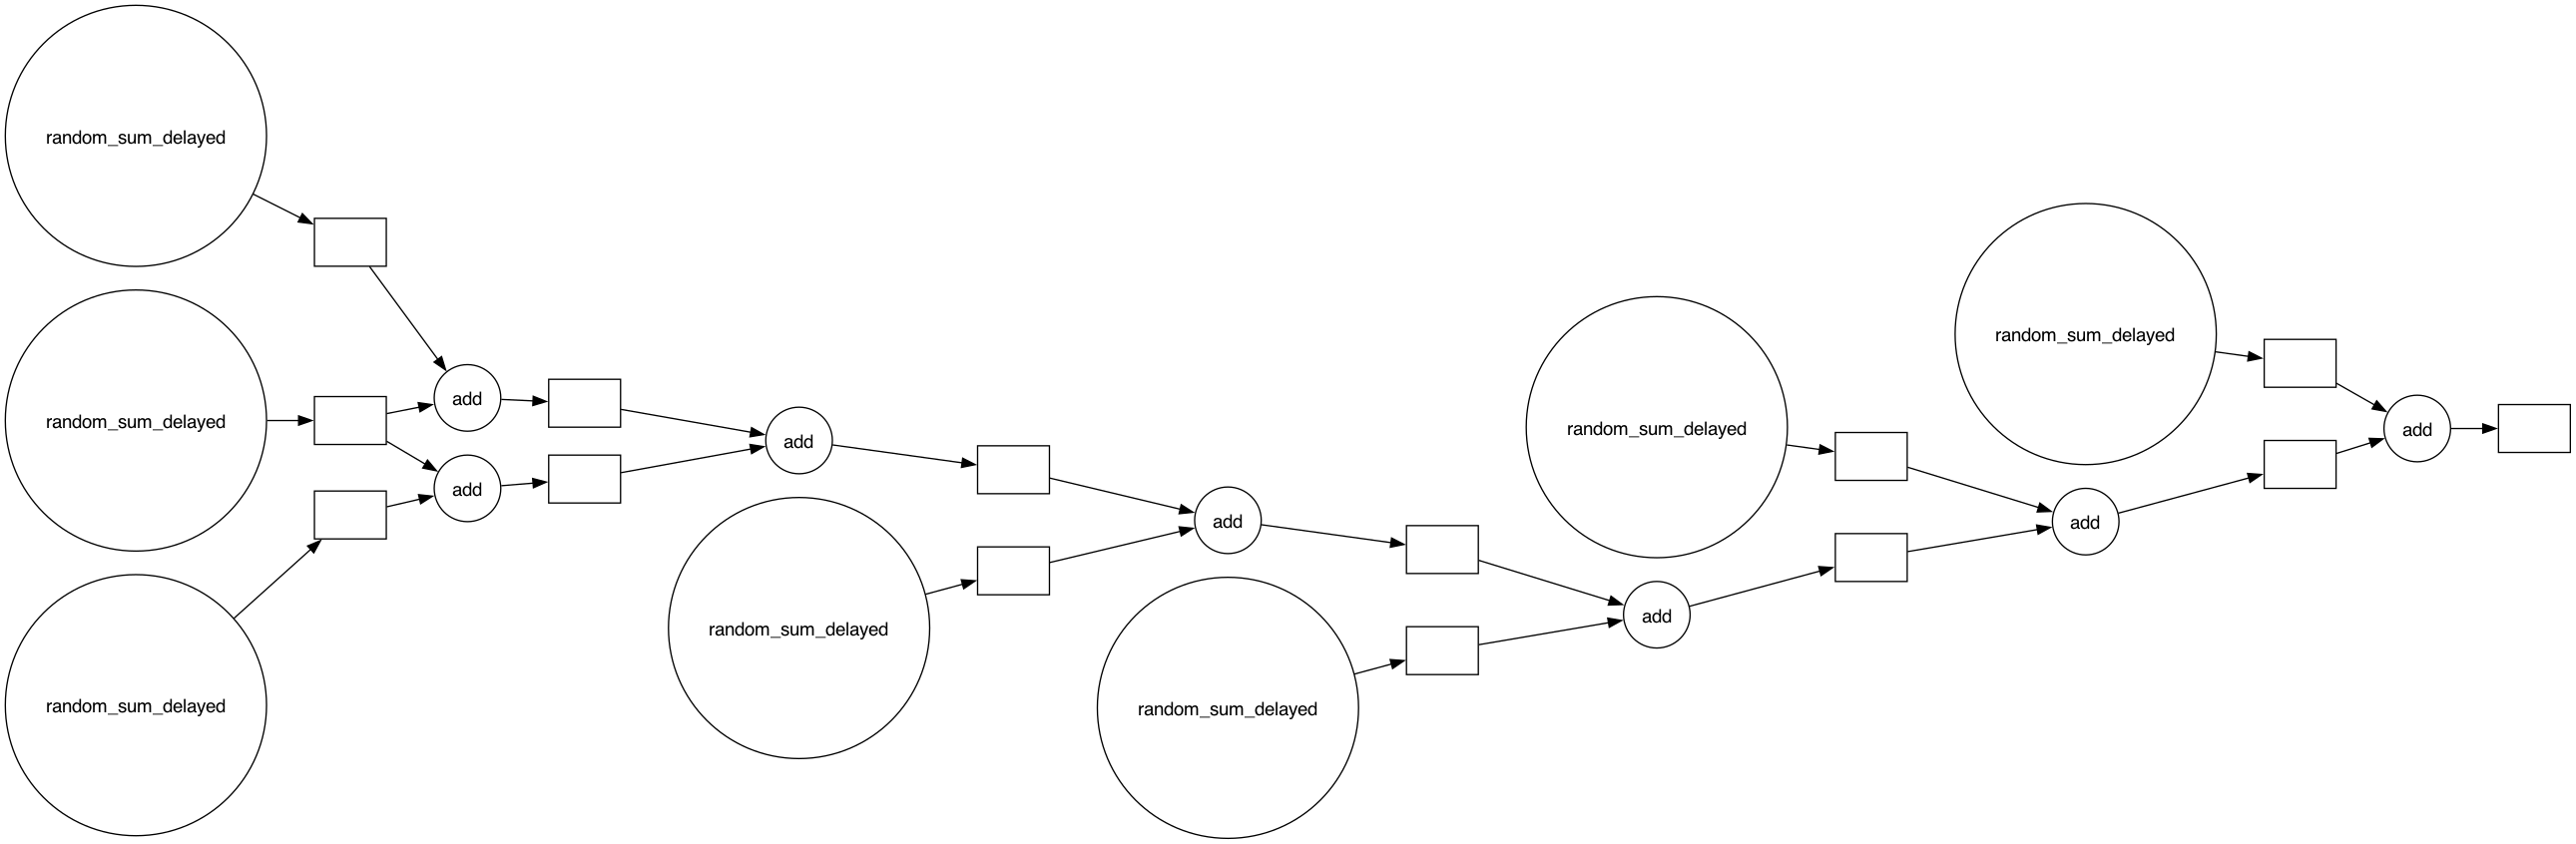

In [51]:
task_6.visualize(rankdir="LR")

> *⭕ **Reflection Question**: Compare the graph above to the sequential workflow diagram of `trad_vs_cloud.ipynb` notebook. Where in the workflow did Dask execute tasks in parallel, and which parts benefited the most from this parallelization? Compare the runtime of the Dask-parallelized version with the serial version—how much faster was it? Now scale up your thinking: if this workflow processes 3 stations, estimate how long it would take to handle 1,000 stations over 10 iterations. Assuming the performance gain remains consistent, how significant is the total time saved using Dask versus running everything serially?*

---

### **4. Dask Futures: dynamic, eager execution with fine-grained control**

In the case of scientific and engineering workflows, involving real-time data & branching computations, waiting to build an entire task graph before execution isn’t always ideal. You may want your tasks to begin executing as soon as they’re defined, inspect results incrementally, or launch new work based on partial outcomes.

This is where `dask.distributed.Futures` shine. Unlike `dask.delayed`, which constructs a lazy task graph and only computes once everything is defined, **Futures provide an eager interface**. Each task is immediately submitted to the scheduler, and you get back a Future object representing that computation.

This model gives you:

- **Real-time scheduling**: tasks start running as soon as their inputs are available.

- **Interactivity**: you can query task status, cancel, or rerun as needed.

- **Dynamic workflows**: ideal for loops, conditionals, and iterative pipelines.

Futures in Dask are powered by the `dask.distributed.Client`, which acts as the gateway to Dask's scheduler and cluster. When you instantiate a `Client()`, Dask spins up a scheduler and one or more workers—either on your local machine or across a distributed computing cluster, depending on your configuration. This means that when you use **Futures**, Dask is **cloud-ready out of the box**. This serves as your entry point not just to the task scheduler, but to the entire compute environment—whether it's running locally or in the cloud. In cloud computing contexts, you can configure `Client` to connect to remote clusters running on cloud infrastructure such as the AWS. This allows you to scale your computations seamlessly without changing your code.

In [2]:
import random
import time
from dask.distributed import Client

# Step 1: Start a local Dask client (scheduler + workers)
client = Client()

# Simulated CPU-bound computation
n_total = 1000000
def random_sum(n=n_total):
    total = 0
    for _ in range(n):
        total += random.randint(1, n)
    return total

# —————— Execution using Futures ——————
start = time.time()

# Task 1: Simulate station inventory creation
task1 = client.submit(random_sum)

# Task 2a: Waveform access from station 1 (depends on task1)
# The lambda ensures that task2a waits for task1 to finish and uses its result.
task2a = client.submit(lambda prev: prev + random_sum(), task1)

# Task 2b: Waveform access from station 2 (also depends on task1)
task2b = client.submit(lambda prev: prev + random_sum(), task1)

# Task 3: Instrument correction (merges results of task2a and task2b)
task3 = client.submit(lambda a, b: a + b + random_sum(), task2a, task2b)

# Task 4: P-arrival pick
task4 = client.submit(lambda prev: prev + random_sum(), task3)

# Task 5: Trace trimming
task5 = client.submit(lambda prev: prev + random_sum(), task4)

# Task 6: Frequency decomposition
task6 = client.submit(lambda prev: prev + random_sum(), task5)

# Wait for the final result and measure runtime
final_result = task6.result()
end = time.time()

print(f"Futures Result: {final_result}")
print(f"Futures Runtime: {end - start:.2f} seconds")


/Users/ece/Library/Python/3.9/lib/python/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63148 instead
  warnings.warn(


Futures Result: 3999016339286
Futures Runtime: 3.76 seconds


🔍 Why use `lambda prev: prev + random_sum()`?
This pattern allows us to explicitly declare task dependencies. For example:
```
client.submit(lambda prev: prev + random_sum(), task1)
```
This ensures:
- `task2a` does not start until task1 is complete.
- The output of `task1` is passed to the lambda as `prev`.
- `random_sum()` is run in the context of that intermediate result.

Key Differences with `dask.delayed`

| **Aspect**              | **Dask Futures**                                                                                          | **Dask Delayed**                                                                                      |
|-------------------------|-----------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| **Eagerness**           | `client.submit` immediately sends tasks to the scheduler and returns a `Future`.                         | Builds a graph of `Delayed` objects; nothing runs until you call `.compute()`.                         |
| **Interactivity**       | You can inspect task status, cancel/re-submit tasks, and gather partial results dynamically.             | More "batch-oriented"—you define the full workflow up front and then execute all at once.              |
| **Dynamic Task Creation** | Supports branching, loops, and callback-based task submission based on real-time results.                | The task graph is static once built; cannot change based on intermediate results.                      |
| **API Style**           | Imperative, message-passing style using `submit`, `Future`, `.result()`, `.cancel()`.                    | Declarative style using function decorators and lazy graph construction.                              |


> *⭕ **Reflection Question**: In terms of writing codes, between `delayed` and `futures`, which process seemed easier to you? Which technique would you want to adopt for your workflow and why?*

---

### **5. Dask Gateway: Secure, Scalable Cluster Access for Multi-User Environments**


While Dask Futures give us powerful tools for building dynamic, interactive, and parallel workflows, they assume you already have a Dask cluster available—whether local or remote. But in many real-world scenarios, especially in cloud-hosted Jupyter environments, or institutional HPC systems, managing and provisioning clusters manually isn’t feasible or secure. You may be working in a multi-user setting where each user needs isolated compute resources without dealing with the infrastructure details. This is where **Dask Gateway** comes in. In these shared-environment scenarios, you don't want every user to manually configure or control cluster infrastructure. You need a centralized, secure, and user-friendly way to let individuals spin up their own isolated Dask clusters—on demand.

**Dask Gateway** is a cluster manager and authentication layer that allows users to launch and scale their own isolated Dask clusters in a shared infrastructure. It integrates seamlessly with Dask’s distributed scheduler and supports backends like **Kubernetes**. It’s particularly well-suited for Jupyter-based environments, where each user or notebook may want its own cluster. Each cluster is isolated, customizable, and tracked, making it ideal for research groups, teaching environments, or collaborative teams.

The following steps show how to spin up a personal Dask cluster and submit tasks using Futures, just like we did before—but now in a shared cloud-native environment.

**Launch a Cluster via Dask Gateway**

In [ ]:
from dask_gateway import Gateway
from dask.distributed import Client

# Step 1: Connect to the Gateway server (usually running alongside JupyterHub)
gateway = Gateway()

# Step 2: Explore and select cluster options (memory, CPU, container image, etc.)
options = gateway.cluster_options()
options

In [ ]:
# Step 3: Request a secure, isolated Dask cluster
cluster = gateway.new_cluster(options)

# Step 4: Scale the cluster to your desired size (or use adaptive scaling)
cluster.scale(4)
# cluster.adapt(minimum=2, maximum=10)  # Optional Adaptive scaling

# Step 5: Connect your Dask client to the newly created cluster
client = Client(cluster)
client

In [ ]:
# Step 6: Submit work (e.g. using Futures or Delayed as before)
future = client.submit(lambda: sum(range(1_000_000)))
result = future.result()
print(f"Gateway Result: {result}")

**Why Use Dask Gateway**
| **Feature**              | **Benefit**                                                                                         |
|--------------------------|------------------------------------------------------------------------------------------------------|
| **Multi-user isolation** | Each user gets their own Dask cluster with no interference from others.                            |
| **Secure authentication**| Integrates with OAuth, tokens, or institutional auth systems for controlled access.                |
| **Centralized control**  | Admins can monitor usage, enforce resource limits, and manage shared infrastructure securely.      |
| **Flexible backend**     | Supports Kubernetes, YARN, SLURM, and other job schedulers for deployment.                         |
| **Notebook integration** | Designed to work seamlessly within JupyterHub and other shared notebook environments.              |


In brief, Dask has high level collections that are used to generate task graphs which can be executed by schedulers on a single machine or a cluster

<img src="https://docs.dask.org/en/latest/_images/dask-overview.svg" alt="DASK_array" width="800"/> 

> *⭕ **Reflection Question**: Look closely at the figure above. Can you trace how a Dask workflow moves from **data collections** to execution. How do the different tools you’ve learned—like `dask.delayed`, `Futures`, and `Dask Gateway`—fit into this pipeline? Try to correlate each step in the diagram with the concepts from Sections 3–5*

---

### **6. DASK on the cloud**

In this section, we'll integrate dask into a real-world seismology workflow to accelerate the downloading and analysis of seismograms. Specifically, we'll be working with the `analyze_earthquake` function from the `trad_vs_cloud-SAGE` notebook. Our goal is to modify this function using `dask.delayed` so we can process multiple stations in parallel, rather than one at a time.

Your first task is to inspect the original `analyze_earthquake` function and identify where it loops over stations — this is the part of the code that holds the key to parallelization. Once you've found it, return to the modified version of the function below to see how `dask.delayed` and `futures` are applied. 🔍 Hint: We've modularized the workflow by separating out the station-level processing into its own function, which is then wrapped with both `dask.delayed` and `futures` to enable parallel execution.

In [ ]:
# ----------------------------------------------
# Import Required Libraries
# ----------------------------------------------
import os
import dask.delayed
import numpy as np
from obspy import UTCDateTime
from obspy import read
from obspy.clients.fdsn.client import Client
from obspy.core.inventory.inventory import Inventory
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import signal
import seisbench.models as sbm  # Import PhaseNet model from SeisBench
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from botocore.exceptions import ClientError
import dask
from io import BytesIO

# ----------------------------------------------
# Configure S3 Client for Public NCEDC Access
# ----------------------------------------------
s3 = boto3.client('s3', config = Config(signature_version = UNSIGNED), region_name='us-west-2')
BUCKET_NAME = 'ncedc-pds'

# -------------------------------------------------------------------------
# 📌 Utility Function to check if data is available in repository
# -------------------------------------------------------------------------
def station_data_exists(station, eq_time, pre_time, post_time, client: Client, network: str, location: str, channel: str,
                        s3_client, bucket_name: str) -> bool:
    """
    Returns True only if:
     - FDSN.get_waveforms() delivers at least one trace in [eq_time-pre_time, eq_time+post_time]
     - There's an S3 object at the expected key for that day & station.
    """
    # 1) FDSN check
    start = eq_time - pre_time
    end   = eq_time + post_time
    try:
        st_temp = client.get_waveforms(network, station.code, location, channel, starttime=start, endtime=end)
        if len(st_temp) == 0:
            return False
    except Exception:
        return False

    # 2) S3 check — build the same key you use in your main function
    day0 = eq_time.replace(hour=0, minute=0, second=0, microsecond=0)
    jul   = day0.julday
    fname = f"{station.code}.{network}.{channel}..D.{day0.year}.{jul:03d}"
    key   = f"continuous_waveforms/{network}/{day0.year}/" \
            f"{day0.year}.{jul:03d}/{fname}"
    try:
        s3_client.head_object(Bucket=bucket_name, Key=key)
    except ClientError:
        return False

    return True

# --------------------------------------------------------------
# 📌 Utility Function to Filter Inventory Based on Data Availability
# --------------------------------------------------------------
def filter_inventory(inventory: Inventory, eq_time, pre_time, post_time, client: Client, network: str, location: str, channel: str,
                     s3_client, bucket_name: str) -> Inventory:
    """
    Modify `inventory` in place so that each Network only keeps
    those Station objects for which `station_data_exists(...)` is True.
    Networks with zero stations are dropped.
    Returns the pruned Inventory.
    """
    # iterate all networks
    kept_networks = []
    for net in inventory.networks:
        kept_stns = []
        for st in net.stations:
            if station_data_exists(st, eq_time, pre_time, post_time, client, network, location, channel,
                                   s3_client, bucket_name):
                kept_stns.append(st)
        if kept_stns:
            net.stations = kept_stns
            kept_networks.append(net)

    inventory.networks = kept_networks
    return inventory

# ----------------------------------------------
# Load Pretrained Phase Picker (PhaseNet)
# ----------------------------------------------
picker = sbm.PhaseNet.from_pretrained("original")

# --------------------------------------------------
# --------------------------------------------------
# ✂️ SEPERATE FUNCTION TO PROCESS STATIONS IN PARALLEL
# --------------------------------------------------
# --------------------------------------------------
def process_stations(station, start_time, end_time, pre_time, post_time, eq_time,
                     network, location, channel, output_dir, data_source, inventory):
    station_code = station.code
    # -----------------------------------------------------------
    # Step 3️⃣: # Download waveforms & apply instrument correction
    # -----------------------------------------------------------
    if data_source == 'fdsn':
        st_stream = client.get_waveforms(network=network, station=station_code, location=location,
                                            channel=channel, starttime=start_time, endtime=end_time)
        if len(st_stream) > 0:
            st_stream.merge(method=1, fill_value='interpolate')

        st_stream.trim(starttime=eq_time - pre_time, endtime=eq_time + post_time)
        
    elif data_source == 'S3':
        file_name = f'{station_code}.{network}.{channel}..D.{start_time.year}.{start_time.julday:03d}'
        KEY = f"continuous_waveforms/{network}/{start_time.year}/{start_time.year}.{start_time.julday:03d}/{file_name}"

        # stream the object from S3 and wrap in a BytesIO
        resp = s3.get_object(Bucket=BUCKET_NAME, Key=KEY)
        data_stream = resp['Body']              # this is a file-like StreamingBody
        buff = BytesIO(data_stream.read())      # read all bytes into an in-memory buffer
        buff.seek(0)                            # rewind to the front
        
        # now read directly from that buffer
        st_stream = read(buff, format='MSEED')
        st_stream.trim(starttime=eq_time - pre_time, endtime=eq_time + post_time)

    print(f"- Downloaded {len(st_stream)} traces for station {station_code}.")

    # Assuming single trace per station
    tr = st_stream[0]

    # Remove the instrument response to convert counts to ground displacement (in meters)
    tr.remove_response(inventory=inventory, output="DISP")

    # ----------------------------------------------
    # Step 4️⃣: Pick P-wave Arrivals & Slice Waveform
    # ----------------------------------------------
    picks = picker.classify(st_stream, batch_size=256, P_threshold=0.075, S_threshold=0.1).picks
    if not picks:
        raise Exception(f"- No picks found for station {station_code}.")
    
    # Use first P arrival time for plotting
    p_time = picks[0].peak_time

    # Slice trace around P arrival
    tr = tr.slice(p_time - pre_time, endtime=p_time + post_time)
    times = np.linspace(0, (p_time + post_time) - (p_time - pre_time), len(tr.data))

    # ----------------------------------------------
    # Step 5️⃣: Compute Spectrogram
    # ----------------------------------------------
    fs = tr.stats.sampling_rate # Sampling rate of the trace
    nperseg = 400               # Window size for the spectrogram
    f, t_spec, Sxx = signal.spectrogram( tr.data, fs=fs, nperseg=nperseg, noverlap=nperseg - 10)
    t_spec = np.linspace(0, (p_time + post_time) - (p_time - pre_time), Sxx.shape[1])

    # Plot waveform and spectrogram
    fig = plt.figure(figsize=(10, 8))
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.plot(times, tr.data, linewidth=0.5)
    #ax1.set_xlim(0, times.max())
    ax1.set_title(f"Waveform at {station_code}")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Deformation (m)")

    ax2 = fig.add_subplot(2, 1, 2)
    pcm = ax2.pcolormesh(t_spec, f, np.abs(Sxx), shading='gouraud')
    #ax2.set_xlim(0, times.max())
    ax2.set_ylim(0, 5)  # Limit frequency for readability
    ax2.set_title(f"Spectrogram at {station_code}")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Frequency (Hz)")
    fig.tight_layout()

    # Save plot
    out_file = os.path.join(f"{output_dir}/{data_source}/{station_code}_{data_source}.png")
    fig.savefig(out_file, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"-- Saved plot to {out_file}")


# ----------------------------------------------
# 🧰 Main Function: Seismogram Analysis Workflow
# ----------------------------------------------
def analyze_earthquake(eq_time, eq_lon, eq_lat, radius_km, data_source='fdsn',
                       client_name='NCEDC', network='NC', location='*', channel='HNE',
                       pre_time=3, post_time=120, output_dir='plots/dask', use_dask=False, method='delayed'):
    """
    Analyze seismic waveforms from stations near an earthquake using FDSN or cloud-based access.

    This function performs data fetching, instrument correction, P-phase picking,
    waveform slicing, and spectrogram plotting in a scalable way.

    Parameters:
    ------------
    eq_time : str or obspy.UTCDateTime
        Earthquake origin time (ISO string like '2022-12-20T10:34:24' or UTCDateTime).
    eq_lon : float
        Earthquake longitude in decimal degrees.
    eq_lat : float
        Earthquake latitude in decimal degrees.
    radius_km : float
        Search radius around epicenter in kilometers.
    data_source : str, optional
        Data source for waveforms ('fdsn' or 'S3', default 'fdsn').
    client_name : str, optional
        Seismic data client (default 'NCEDC').
    network : str, optional
        Seismic network code (default 'NC').
    location : str, optional
        Station location code wildcard (default '*').
    channel : str, optional
        Channel code (default 'HHZ').
    pre_time : float, optional
        Seconds before eq_time to start waveform window (default 10 s).
    post_time : float, optional
        Seconds after eq_time to end waveform window (default 200 s).
    output_dir : str, optional
        Directory to save plots (default 'plots').

    Requirements:
    -------------
    - SeisBench PhaseNet picker pre-loaded above.
    - Necessary packages installed: obspy, boto3, utm, numpy, matplotlib, cartopy, scipy, seisbench.

    """
    # Ensure eq_time is UTCDateTime
    if not isinstance(eq_time, UTCDateTime):
        eq_time = UTCDateTime(eq_time)

    # Define waveform time window
    start_time = eq_time.replace(hour=0, minute=0, second=0, microsecond=0)
    end_time = eq_time.replace(hour=23, minute=59, second=59, microsecond=999999)

    # Create output directory if it doesn't exist
    os.makedirs(f"{output_dir}/{data_source}", exist_ok=True)

    # ----------------------------------------------
    # Step 1️⃣: Retrieve Station Metadata
    # ----------------------------------------------
    client = Client(client_name)
    print("Making inventory of stations ...")
    inventory = client.get_stations(network=network, latitude=eq_lat, longitude=eq_lon,
                                    starttime=start_time, endtime=end_time, maxradius=radius_km/111.2, # Convert km to degrees
                                    location=location, channel=channel, level="response")
    
    print("Filtering the inventory ...")
    inventory = filter_inventory(inventory, eq_time, pre_time, post_time, client, network, location, channel, s3, BUCKET_NAME)

    stations = inventory[0].stations
    print(f"Found {len(stations)} stations within {radius_km} km of ({eq_lat}, {eq_lon}).")

    # ----------------------------------------------
    # Step 2️⃣: Plot Station Locations on a Map
    # ----------------------------------------------
    st_latlon = [(station.latitude, station.longitude) for network in inventory for station in network.stations]
    
    # Create a plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Add geographic features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot the stations
    if st_latlon:
        lats, lons = zip(*st_latlon)
        ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree(), label='PNSN Stations')

    ax.plot(eq_lon, eq_lat, marker='*', color='blue', markersize=10, transform=ccrs.PlateCarree(), label='Earthquake Epicenter')
    
    out_file = os.path.join(output_dir, f"st_event.png")
    fig.savefig(out_file, dpi=300, bbox_inches='tight')
    
    # Loop Over Each Station
    if use_dask and method == 'delayed':
        # --------------------------
        # 1) Dask.delayed version
        # --------------------------        
        tasks = [dask.delayed(process_stations)(
            st, start_time, end_time, pre_time, post_time, eq_time,
                             network, location, channel, output_dir, data_source, inventory
        ) for st in stations]
        # run them (you can swap 'threads' for 'processes' if you like)
        dask.compute(*tasks, scheduler='threads')

    elif use_dask and method == 'futures':
        # --------------------------
        # 2) Dask Futures version
        # --------------------------
        futures = []
        for st in stations:
            # submit each job immediately to the cluster
            fut = client.submit(
                process_stations,
                st, start_time, end_time, pre_time, post_time, eq_time,
                network, location, channel, output_dir, data_source, inventory
            )
            futures.append(fut)
        # wait for all to finish (and gather exceptions/results)
        client.gather(futures)

    else:
        # --------------------------
        # 3) Simple Python sequential
        # --------------------------
        for st in stations:
            process_stations(st, start_time, end_time, pre_time, post_time, eq_time,
                             network, location, channel, output_dir, data_source, inventory)
 

Now, we are going to compare the processing time for the entire workflow with and without using `dask`.


🔄 Running analysis without DASK
Making inventory of stations ...
Filtering the inventory ...
Found 7 stations within 150 km of (40.369, -124.588).
- Downloaded 1 traces for station KCO.
-- Saved plot to plots/dask/S3/KCO_S3.png
- Downloaded 1 traces for station KCT.
-- Saved plot to plots/dask/S3/KCT_S3.png
- Downloaded 1 traces for station KHBB.
-- Saved plot to plots/dask/S3/KHBB_S3.png
- Downloaded 1 traces for station KHMB.
-- Saved plot to plots/dask/S3/KHMB_S3.png
- Downloaded 1 traces for station KMPB.
-- Saved plot to plots/dask/S3/KMPB_S3.png
- Downloaded 1 traces for station KMR.
-- Saved plot to plots/dask/S3/KMR_S3.png
- Downloaded 1 traces for station KRMB.
-- Saved plot to plots/dask/S3/KRMB_S3.png
⏱ run completed in 30.13 seconds
   

🔄 Running analysis with DASK
Making inventory of stations ...
Filtering the inventory ...
Found 7 stations within 150 km of (40.369, -124.588).
- Downloaded 1 traces for station KMR.
- Downloaded 1 traces for station KMPB.
- Downloaded 1 t

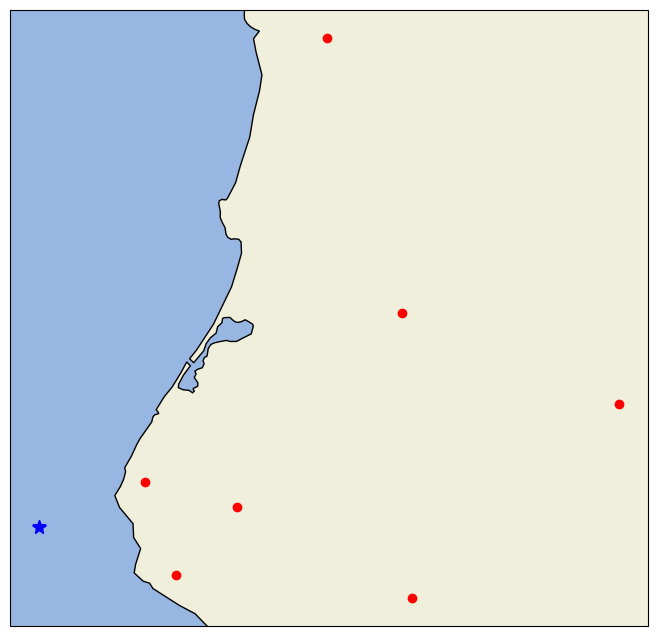

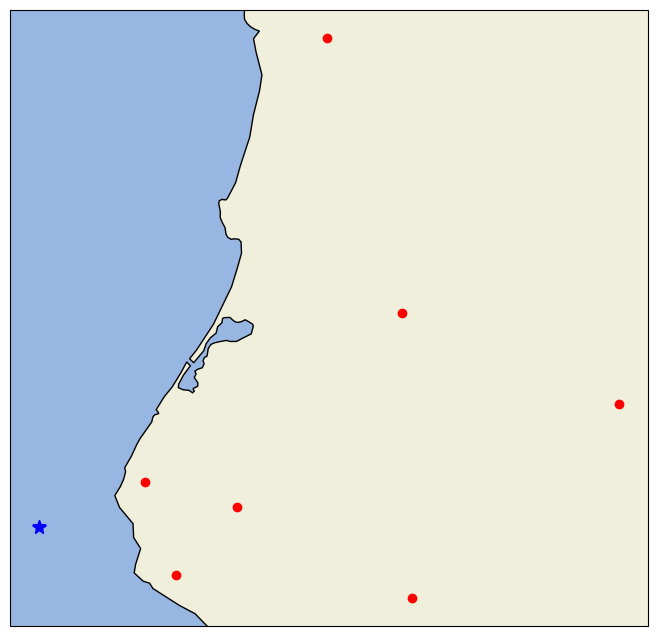

In [ ]:
import time

# Earthquake parameters (2022 Ferndale Earthquake)
event_time = "2022-12-20T10:34:24"  # UTC
event_lat  = 40.369
event_lon  = -124.588

search_radius_km = 150  # You can adjust this as needed

print(f"\n🔄 Running analysis without DASK")
start = time.perf_counter()
analyze_earthquake(event_time, event_lon, event_lat, search_radius_km, data_source='S3', use_dask=False)
elapsed = time.perf_counter() - start
print(f"⏱ run completed in {elapsed:.2f} seconds")

print('   ')

print(f"\n🔄 Running analysis with DASK delayed")
start = time.perf_counter()
analyze_earthquake(event_time, event_lon, event_lat, search_radius_km, data_source='S3', use_dask=True, method='delayed')
elapsed = time.perf_counter() - start
print(f"⏱ run completed in {elapsed:.2f} seconds")

How much time it has saved you while processing with `dask`?

> *⭕ **Reflection Question:** We only employed dask while looping over stations. Is there any other place in the function `analyze_earthquake` where you can employ dask too to make things even faster?*